# DA10 Preprocess
01/30/2024

In [2]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy


import warnings
warnings.filterwarnings('ignore')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [5]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [7]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'DA10'
subj_format = ['nlx']
subj_site = ['MSSM']


# Make mne_data


### Load and resample data


In [8]:
load_path = f'{neural_dir}{subj_id}/raw_nlx/'
seeg_names = None
resp_names = None
ekg_names = None
eeg_names = None

In [9]:
### removing extraneous numbering from channel names 

# per Shawn, MSSM data seems to sometime have a "_0000.ncs" to "_9999.ncs" appended to the end of real data
pattern = re.compile(r"_\d{4}\.ncs")  # regex pattern to match "_0000.ncs" to "_9999.ncs"
ncs_files = [x for x in glob(f'{load_path}/*.ncs') if re.search(pattern, x)]
# just in case this changes in the future: 
if len(ncs_files) == 0: 
    ncs_files = glob(f'{load_path}/*.ncs')
    if not seeg_names:
        seeg_names = [x.split('/')[-1].replace('.ncs','') for x in glob(f'{load_path}/[R,L]*.ncs')]
else:
    if not seeg_names:
        seeg_names = [x.split('/')[-1].replace('.ncs','').split('_')[0] for x in glob(f'{load_path}/[R,L]*.ncs') if re.search(pattern, x)]

In [10]:
seeg_names = [x.lower() for x in seeg_names] 
seeg_names

['ltt8',
 'ltt4',
 'ltt2',
 'lad6',
 'ltpo1',
 'lad5',
 'ltpo8',
 'ltpo5',
 'ltpo2',
 'ltpo6',
 'lhb4',
 'lhh5',
 'lad4',
 'lad7',
 'lof1',
 'lad1',
 'lhh2',
 'lof8',
 'lhb9',
 'ltt5',
 'lhh4',
 'lhh6',
 'lhb3',
 'lhb6',
 'lof3',
 'lad3',
 'lhb5',
 'lhh8',
 'ltpo4',
 'ltt6',
 'ltt1',
 'lhh1',
 'ltpo7',
 'ltpo3',
 'lhb1',
 'lad9',
 'lof4',
 'lhh3',
 'lof7',
 'lhb2',
 'lof6',
 'lhb7',
 'lad8',
 'lof2',
 'ltt7',
 'lhh7',
 'lhh9',
 'ltt3',
 'lof5',
 'lad2',
 'lhb8',
 'lof9']

In [11]:
### empty vecs to load data into 

signals = [] #data
srs = [] #sampling rate
ch_name = [] #channel name
ch_type = [] #channel type (seeg, eeg etc.)

In [12]:
ncs_files.sort() ### added to make channels in alphabetical order 

In [13]:
ncs_files

['/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA10/raw_nlx/LAD1_0002.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA10/raw_nlx/LAD2_0002.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA10/raw_nlx/LAD3_0002.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA10/raw_nlx/LAD4_0002.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA10/raw_nlx/LAD5_0002.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA10/raw_nlx/LAD6_0002.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA10/raw_nlx/LAD7_0002.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA10/raw_nlx/LAD8_0002.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA10/raw_nlx/LAD9_0002.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA10/raw_nlx/LHB1_0002.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA10/raw_nlx/LHB2_0002.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA10/raw_

In [14]:
for chan_path in ncs_files:
    chan_name = chan_path.split('/')[-1].replace('.ncs','')
    # strip the file type off the end if needed 
    if '_' in chan_name:
        chan_name = chan_name.split('_')[0]
    try:
        fdata = nlx_utils.load_ncs(chan_path)
    except IndexError: 
        print(f'No data in channel {chan_name}')
        continue
    if eeg_names:
        if chan_name.lower() in eeg_names:
            ch_type.append('eeg')
    if resp_names:
        if chan_name.lower() in resp_names:
            ch_type.append('bio')
    if ekg_names:
        if chan_name.lower() in ekg_names: 
            ch_type.append('ecg') 
    if seeg_names: 
        if chan_name.lower() in seeg_names:
            ch_type.append('seeg')  
        elif chan_name.lower()[0] == 'u':
            # microwire data
            ch_type.append('seeg')  
    signals.append(fdata['data'])
    srs.append(fdata['sampling_rate'])
    ch_name.append(chan_name)
    if len(ch_type) < len(ch_name):
        ch_type.append('misc')
        print(f'Unidentified data type in {chan_name}') #this output should tell you what your photodiode name is

Unidentified data type in Photodiode


In [15]:
ch_name

['LAD1',
 'LAD2',
 'LAD3',
 'LAD4',
 'LAD5',
 'LAD6',
 'LAD7',
 'LAD8',
 'LAD9',
 'LHB1',
 'LHB2',
 'LHB3',
 'LHB4',
 'LHB5',
 'LHB6',
 'LHB7',
 'LHB8',
 'LHB9',
 'LHH1',
 'LHH2',
 'LHH3',
 'LHH4',
 'LHH5',
 'LHH6',
 'LHH7',
 'LHH8',
 'LHH9',
 'LOF1',
 'LOF2',
 'LOF3',
 'LOF4',
 'LOF5',
 'LOF6',
 'LOF7',
 'LOF8',
 'LOF9',
 'LTPO1',
 'LTPO2',
 'LTPO3',
 'LTPO4',
 'LTPO5',
 'LTPO6',
 'LTPO7',
 'LTPO8',
 'LTT1',
 'LTT2',
 'LTT3',
 'LTT4',
 'LTT5',
 'LTT6',
 'LTT7',
 'LTT8',
 'Photodiode']

In [16]:
srs

[4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000]

In [17]:
target_sr = 500 #downsampling to 500 to be consistent with other data - alternative = np.min(srs)
mne_data_resampled = []

In [18]:
### resampling to 500Hz

for sr in np.unique(srs):
    ch_ix = np.where(srs==sr)[0].astype(int)
    info = mne.create_info([x for ix, x in enumerate(ch_name) if ix in ch_ix], sr, [x for ix, x in enumerate(ch_type) if ix in ch_ix])
    mne_data_temp = mne.io.RawArray([x for ix, x in enumerate(signals) if ix in ch_ix], info)
    if sr != target_sr:
        # resample down to one sample rate 
        mne_data_temp.resample(sfreq=target_sr, npad='auto', n_jobs=-1)
        mne_data_resampled.append(mne_data_temp)
    else: 
        mne_data = mne_data_temp
        

Creating RawArray with float64 data, n_channels=53, n_times=12682240
    Range : 0 ... 12682239 =      0.000 ...  3170.560 secs
Ready.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:   20.7s finished


In [19]:
### make sure timing is aligned post resampling --- check this 

#Because of the resampling, the end timings might not match perfectly:https://github.com/mne-tools/mne-python/issues/8257

if mne_data_resampled[0].tmax > mne_data_temp.tmax:
    mne_data_resampled[0].crop(tmin=0, tmax=mne_data_temp.tmax)
elif mne_data_resampled[0].tmax < mne_data_temp.tmax:
    mne_data_temp.crop(tmin=0, tmax=mne_data_resampled[0].tmax)
    

In [20]:
mne_data_resampled[0]

<RawArray | 53 x 1585280 (3170.6 s), ~641.1 MB, data loaded>

In [21]:
mne_data = mne_data_resampled[0]  #mne_data.add_channels([mne_data_temp]) to add more channels input mne object as list
# mne_data.add_channels([mne_data_resampled[1]])
mne_data

<RawArray | 53 x 1585280 (3170.6 s), ~641.1 MB, data loaded>

In [22]:
mne_data

<RawArray | 53 x 1585280 (3170.6 s), ~641.1 MB, data loaded>

In [23]:
# mne_data.ch_names

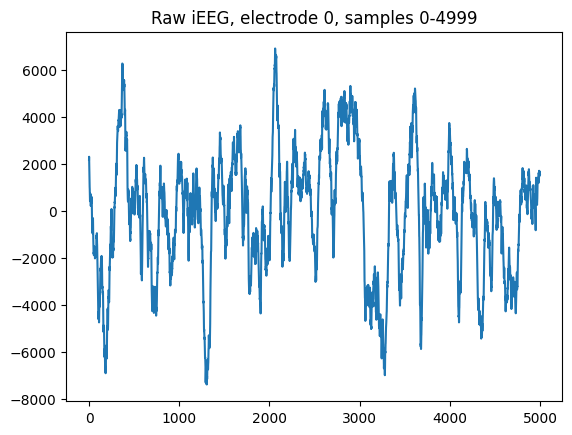

In [24]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Photodiode
- examine photodiode 

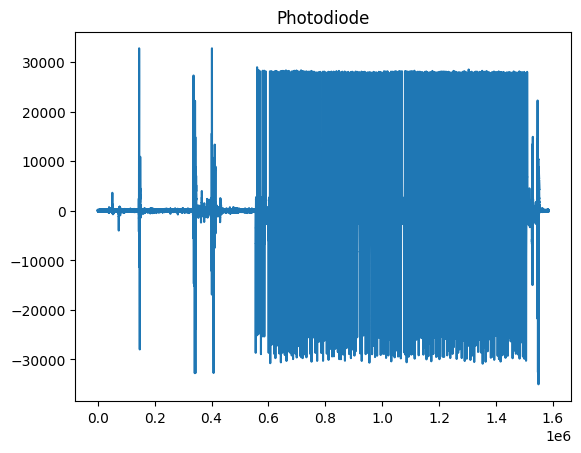

In [25]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("Photodiode")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [26]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='Photodiode', overwrite=True)

Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA10/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA10/photodiode.fif
[done]


In [27]:
mne_data.drop_channels(['Photodiode'])

<RawArray | 52 x 1585280 (3170.6 s), ~629.0 MB, data loaded>

### Notch filter line noise

In [28]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    3.2s finished


<RawArray | 52 x 1585280 (3170.6 s), ~629.0 MB, data loaded>

### Anatomical Localization

In [29]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawArray | 52 x 1585280 (3170.6 s), ~629.0 MB, data loaded>

In [30]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination
0,LAD1,rHipp_L,-14.399994,7.691510,-14.025760,-14.342856,-5.763441,-22.991499,Gray,Left PHG parahippocampal gyrus,Amygdala (LB),L ParaHippocampal Gyrus,L Hipp,Left parahippocampal gyrus A,NaN
1,LAD2,rHipp_L,-19.599993,7.291924,-14.025760,-20.094629,-6.129953,-22.869272,Gray,Left Amygdala,Amygdala (LB),L Hippocampus,L Hipp,Left amygdala inferior,NaN
2,LAD3,rHipp_L,-24.799993,6.892338,-13.626463,-25.843869,-6.282030,-22.239514,Gray,Left Amygdala,Amygdala (LB),L Hippocampus,L Hipp,Left amygdala inferior,NaN
3,LAD4,lAmyg_L,-29.599993,6.892338,-13.626463,-31.162715,-6.120036,-22.229235,Gray,Left Amygdala,Amygdala (LB),L Hippocampus,L Amyg,Left amygdala inferior,NaN
4,LAD5,Unknown,-34.799992,6.492752,-13.227165,-36.913993,-6.484951,-21.801391,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM
5,LAD6,Unknown,-39.599992,6.093167,-13.227165,-42.078518,-7.123732,-21.935039,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM
6,LAD7,aSTS_L,-44.799992,6.093167,-13.227165,-47.687519,-7.375745,-22.114078,White,Left Cerebral White Matter,Unknown,L Middle Temporal Gyrus,L MTG,Left superior middle temporal gyrus A,WM
7,LAD8,aSTS_L,-49.599992,5.693581,-12.827868,-52.874503,-7.931650,-21.592201,White,Left MTG middle temporal gyrus,Unknown,L Middle Temporal Gyrus,L MTG,Left superior middle temporal gyrus A,WM
8,LAD9,A21r_L,-54.799991,5.693581,-12.827868,-58.525474,-8.184515,-21.581147,White,Left MTG middle temporal gyrus,Unknown,L Middle Temporal Gyrus,L MTG,Left inferior middle temporal gyrus A,NaN
9,LHB1,cHipp_L,-26.399993,-14.685300,-10.432084,-26.654716,-29.075918,-14.281852,Gray,Left Hippocampus,Subiculum,L ParaHippocampal Gyrus,L Hipp,Left hippocampus body,NaN


In [31]:
list(elec_locs.label)

['LAD1',
 'LAD2',
 'LAD3',
 'LAD4',
 'LAD5',
 'LAD6',
 'LAD7',
 'LAD8',
 'LAD9',
 'LHB1',
 'LHB2',
 'LHB3',
 'LHB4',
 'LHB5',
 'LHB6',
 'LHB7',
 'LHB8',
 'LHB9',
 'LHH1',
 'LHH2',
 'LHH3',
 'LHH4',
 'LHH5',
 'LHH6',
 'LHH7',
 'LHH8',
 'LHH9',
 'LOF1',
 'LOF2',
 'LOF3',
 'LOF4',
 'LOF5',
 'LOF6',
 'LOF7',
 'LOF8',
 'LOF9',
 'LTT1',
 'LTT2',
 'LTT3',
 'LTT4',
 'LTT5',
 'LTT6',
 'LTT7',
 'LTT8',
 'LTPO1',
 'LTPO2',
 'LTPO3',
 'LTPO4',
 'LTPO5',
 'LTPO6',
 'LTPO7',
 'LTPO8']

In [32]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

[]


In [33]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


In [34]:
unmatched_seeg #make sure there are no unmatched names


[]

In [35]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [36]:
new_name_dict #make sure this passes the eye test 


{'lad1': 'lad1',
 'lad2': 'lad2',
 'lad3': 'lad3',
 'lad4': 'lad4',
 'lad5': 'lad5',
 'lad6': 'lad6',
 'lad7': 'lad7',
 'lad8': 'lad8',
 'lad9': 'lad9',
 'lhb1': 'lhb1',
 'lhb2': 'lhb2',
 'lhb3': 'lhb3',
 'lhb4': 'lhb4',
 'lhb5': 'lhb5',
 'lhb6': 'lhb6',
 'lhb7': 'lhb7',
 'lhb8': 'lhb8',
 'lhb9': 'lhb9',
 'lhh1': 'lhh1',
 'lhh2': 'lhh2',
 'lhh3': 'lhh3',
 'lhh4': 'lhh4',
 'lhh5': 'lhh5',
 'lhh6': 'lhh6',
 'lhh7': 'lhh7',
 'lhh8': 'lhh8',
 'lhh9': 'lhh9',
 'lof1': 'lof1',
 'lof2': 'lof2',
 'lof3': 'lof3',
 'lof4': 'lof4',
 'lof5': 'lof5',
 'lof6': 'lof6',
 'lof7': 'lof7',
 'lof8': 'lof8',
 'lof9': 'lof9',
 'ltpo1': 'ltpo1',
 'ltpo2': 'ltpo2',
 'ltpo3': 'ltpo3',
 'ltpo4': 'ltpo4',
 'ltpo5': 'ltpo5',
 'ltpo6': 'ltpo6',
 'ltpo7': 'ltpo7',
 'ltpo8': 'ltpo8',
 'ltt1': 'ltt1',
 'ltt2': 'ltt2',
 'ltt3': 'ltt3',
 'ltt4': 'ltt4',
 'ltt5': 'ltt5',
 'ltt6': 'ltt6',
 'ltt7': 'ltt7',
 'ltt8': 'ltt8'}

In [37]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawArray | 52 x 1585280 (3170.6 s), ~629.0 MB, data loaded>

In [38]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 52 left sEEG and 0 right sEEG electrodes
We have a total of 52 sEEG electrodes


In [39]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawArray | 52 x 1585280 (3170.6 s), ~629.0 MB, data loaded>

In [40]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawArray | 52 x 1585280 (3170.6 s), ~629.0 MB, data loaded>

In [41]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawArray | 52 x 1585280 (3170.6 s), ~629.0 MB, data loaded>

## Signal Cleaning 
Methods:
- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary
    - remove ch if there is massive artifact in a channel not in the rest of probe 
    - if entire probe shows same artifact try to keep
- Remove additional channels as needed
- This process is iterative depending on how TFRs look. 

In [42]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [43]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [44]:
probe_ch_counts

{'lad': 9, 'lhb': 9, 'lhh': 9, 'lof': 9, 'ltpo': 8, 'ltt': 8}

### Compare auto detection result to actual lfp data - if trusted save auto result as mne bads
- often inaccurate - verify that all included channels make sense and all channels that should be included are
- take out any crazy noise, especially if it's only in one channel on probe (won't be cancelled out)

In [2045]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) # good for this patient

<IPython.core.display.Javascript object>


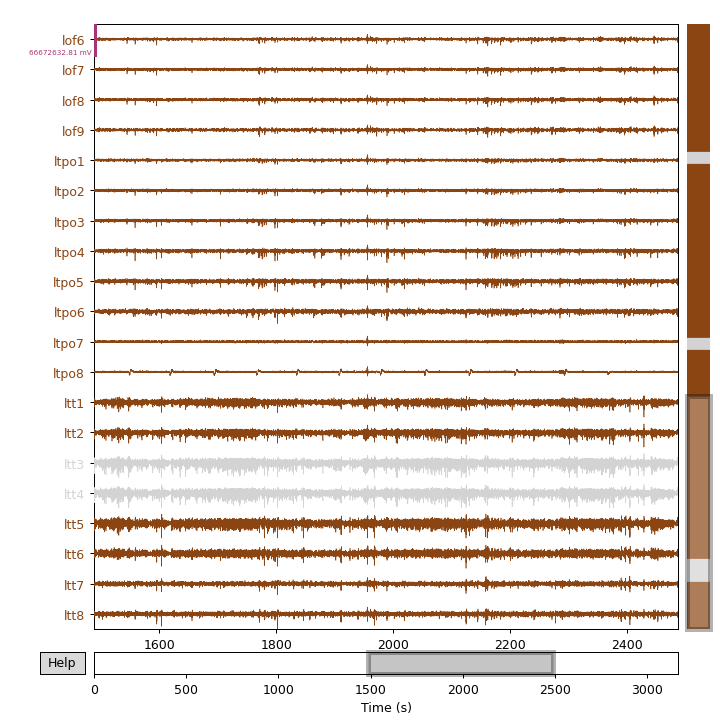

In [2063]:
 %matplotlib notebook
fig = mne_data.plot(start=0, duration=1000, n_channels=20, scalings=mne_data._data.max())


In [2064]:
mne_data.info['bads']

['lhb3', 'lof1', 'ltt3', 'ltt4']

In [2065]:
mne_data.info #sanity check that bads info saved

<Info | 12 non-empty values
 bads: 4 items (lhb3, lof1, ltt3, ltt4)
 ch_names: lad1, lad2, lad3, lad4, lad5, lad6, lad7, lad8, lad9, lhb1, ...
 chs: 52 sEEG
 custom_ref_applied: False
 dig: 52 items (52 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 52
 projs: []
 sfreq: 500.0 Hz
>

# Bipolar Re-referencing 
- plot lfp bp data
- plot psd bp data
- save bp reref data 


In [2066]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [2067]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=11, n_times=1585280
    Range : 0 ... 1585279 =      0.000 ...  3170.558 secs
Ready.
Added the following bipolar channels:
lad1-lad2, lad2-lad3, lad3-lad4, lhb6-lhb7, lhh1-lhh2, lhh6-lhh7, lhh7-lhh8, lof3-lof4, ltt1-ltt2, ltt6-ltt7, ltt7-ltt8


In [2068]:
mne_data_bp_reref

<Raw | raw_ieeg.fif, 11 x 1585280 (3170.6 s), ~133.1 MB, data loaded>

In [2069]:
mne_data_bp_reref.ch_names

['lad1-lad2',
 'lad2-lad3',
 'lad3-lad4',
 'lhb6-lhb7',
 'lhh1-lhh2',
 'lhh6-lhh7',
 'lhh7-lhh8',
 'lof3-lof4',
 'ltt1-ltt2',
 'ltt6-ltt7',
 'ltt7-ltt8']

#### Examine bp ref data 
- examine lfp plot to see if major artifacts are still present
- examine psd to see if there are any major peaks in channels

<IPython.core.display.Javascript object>


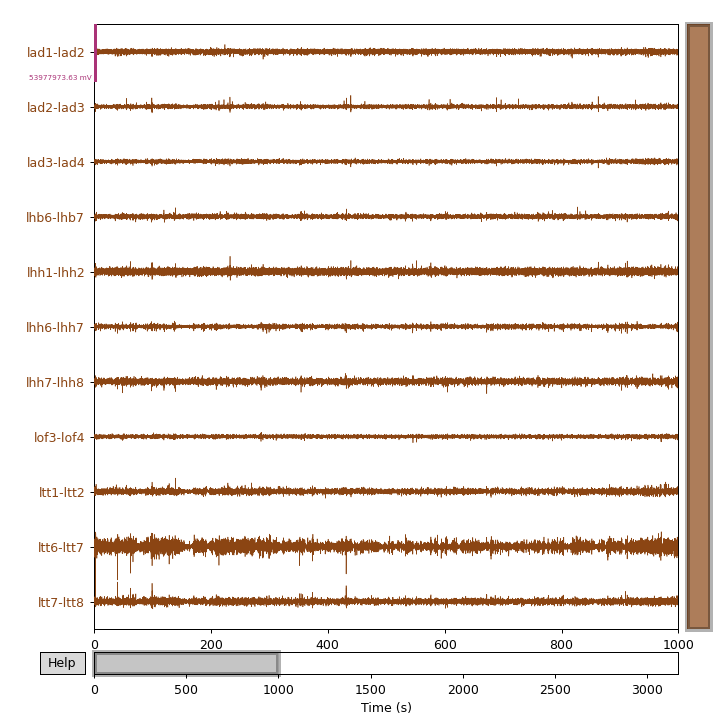

In [2070]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=1000, n_channels=40, scalings=mne_data_bp_reref._data.max())


Effective window size : 0.512 (s)


<IPython.core.display.Javascript object>


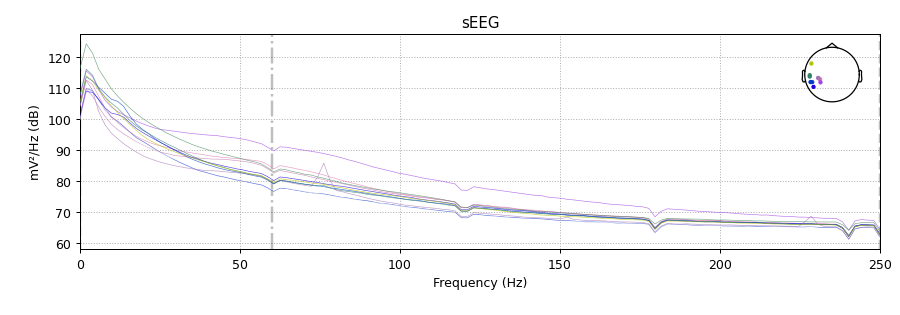

<IPython.core.display.Javascript object>


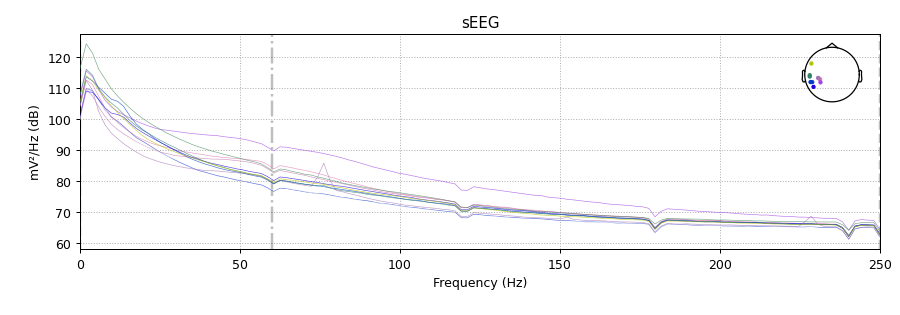

In [2071]:
mne_data_bp_reref.compute_psd().plot()

In [2072]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA10/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA10/bp_ref_ieeg.fif
[done]


## Save mne_data

In [2073]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA10/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA10/raw_ieeg.fif
[done]


# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [2074]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

### Photodiode Alignment

In [2075]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA10/photodiode.fif...
Isotrak not found
    Range : 0 ... 1585279 =      0.000 ...  3170.558 secs
Ready.
Reading 0 ... 1585279  =      0.000 ...  3170.558 secs...


In [2076]:
photodiode_data

<Raw | photodiode.fif, 1 x 1585280 (3170.6 s), ~12.1 MB, data loaded>

<IPython.core.display.Javascript object>


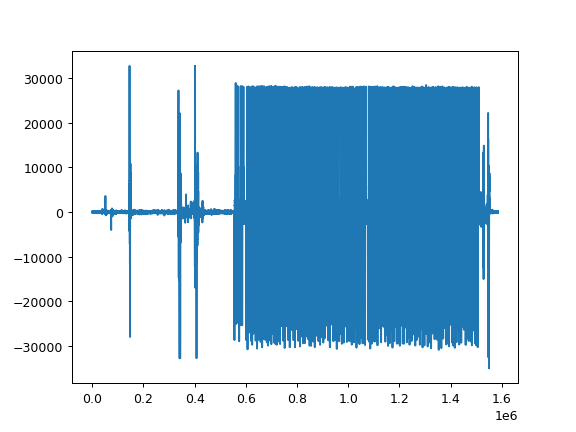

In [2079]:
# plt.plot(scipy.stats.zscore(photodiode_data._data[0,:]))
plt.plot(photodiode_data._data[0,:])


In [369]:
# temp_diode = photodiode_data.copy()
# temp_data = temp_diode._data[0,:]
# temp_data[temp_data<0] = 0 #necessary to get photodiode to align
# temp_data[0:500000] = 0 #np.min(temp_data)
# # temp_data[-50000:] = 0
# temp_diode._data = temp_data


In [2080]:
bad_peak_indices_start = scipy.signal.find_peaks(photodiode_data._data[0, :], height=2500)[0]- 100
bad_peak_indices_end = scipy.signal.find_peaks(photodiode_data._data[0, :], height=2500)[0] + 1000

In [1255]:
# bad_peak_indices_start = scipy.signal.find_peaks(photodiode_data._data[0, :], height=2000)[0]- 100
# bad_peak_indices_start

In [2081]:
temp_diode = photodiode_data.copy()
for (a,b) in zip(bad_peak_indices_start, bad_peak_indices_end):
    temp_diode._data[a:b] = 0

In [2082]:
temp_diode._data[0,temp_diode._data[0,:]<0] = 0
temp_diode._data[0,0:500000] = 0 #np.min(temp_data)
# temp_diode._data[0,-50000:] = 0 #np.min(temp_data)


<IPython.core.display.Javascript object>


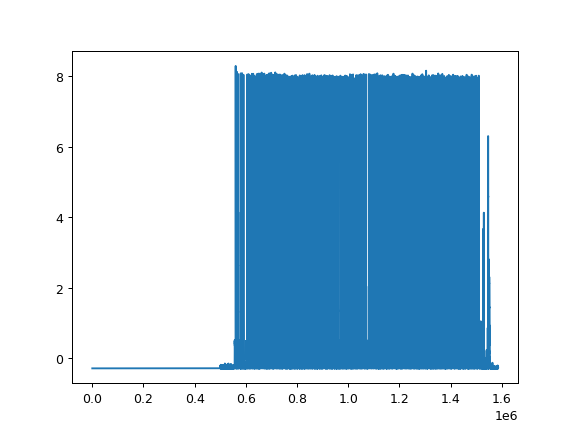

In [2083]:
# Sanity check the photodiode
plt.plot(scipy.stats.zscore(temp_diode._data[0,:]))
# plt.plot(scipy.stats.zscore(-photodiode_data._data[0,:]))
plt.show()

In [ ]:
# temp_diode = photodiode_data.copy()
# temp_data = temp_diode._data[0,:]
# temp_data[temp_data>200] = -10000
# temp_data[temp_data<-1000] = -10000
# temp_diode._data = temp_data

In [102]:
# temp_diode = photodiode_data.copy()
# temp_data = -temp_diode._data[0,:]
# temp_data[780000:] = -5
# temp_diode._data = temp_data

In [2091]:
### Photodiode alignment
smoothSize=15
windSize=15
height=0.45



# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            temp_diode, #
                                            smoothSize, windSize, height)

15 blocks
...............

found matches for 15 of 229 pulses


In [2092]:
print(slope, offset,smoothSize,windSize,height)

0.998394239793615 833.4354755110612 15 15 0.45


In [2085]:
# print(slope, offset,smoothSize,windSize,height)

1.0022938834712514 827.360805384161 10 13 0.45


In [1737]:
# print(slope, offset,smoothSize,windSize,height)

1.0022938834712514 827.360805384161 10 13 0.45


In [631]:
# print(slope, offset,smoothSize,windSize,height)

0.9970658466908027 835.5500628920943 11 14 0.5101


In [510]:
# print(slope, offset,smoothSize,windSize,height)

1.0330210722100528 728.4014617047585 10 20 7.955


In [498]:
# print(slope, offset,smoothSize,windSize,height)

1.0330209885977122 728.401663589593 10 15 7.9561


In [471]:
# print(slope, offset,smoothSize,windSize,height)

1.0330209187456505 728.4015276098517 10 10 7.95279


In [2093]:
[(x*slope + offset) for x in beh_ts]

[1211.8359516224943,
 1222.9287184506202,
 1232.125272239372,
 1249.6116150055486,
 1259.1752529970588,
 1268.5770037587326,
 1286.086526843011,
 1297.491419166338,
 1308.6884294352744,
 1325.0891991750327,
 1336.9270847966977,
 1346.1326530870406,
 1362.5455365437892,
 1373.5984033448372,
 1383.0151164419462,
 1399.6524453135235,
 1408.727057625973,
 1418.2013468209784,
 1432.1686802605363,
 1440.9692172800153,
 1450.4545050854845,
 1465.9325080505587,
 1476.9191080313713,
 1486.658394120525,
 1502.5900651318548,
 1512.7144963755645,
 1522.7080492166137,
 1540.678462731078,
 1552.1563380726916,
 1564.659493113064,
 1581.576693355532,
 1593.5179739825821,
 1602.4825694398507,
 1619.7486314929306,
 1632.2241924141065,
 1642.6401576711794,
 1657.1213258882626,
 1669.894671769137,
 1679.6291786449037,
 1697.471462136371,
 1706.9640654759532,
 1718.9468535448077,
 1735.159833814412,
 1747.3304926227115,
 1758.3992277021282,
 1776.2585720538827,
 1789.1397926352572,
 1799.5251814696999,
 18

In [837]:
# del epochs_all_baseline, power_epochs, plot_data

## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [2094]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [2095]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [2096]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [2097]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA10/bp_ref_ieeg.fif...
    Range : 0 ... 1585279 =      0.000 ...  3170.558 secs
Ready.
Reading 0 ... 1585279  =      0.000 ...  3170.558 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    1.1s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 11 columns
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA10/bp_ref_ieeg.fif...
    Range : 0 ... 1585279 =      0.000 ...  3170.558 secs
Ready.
Reading 0 ... 1585279  =      0.000 ...  3170.558 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.8s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 3501 original time points ...
0 bad epochs dropped
Adding metadata with 11 columns


In [2098]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~18.9 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 6 sec, baseline off, ~44.1 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add behavioral data to metadata 

In [2099]:
behav_df.columns

Index(['Round', 'Trial Num', 'TrialType', 'TrialOnset', 'ChoiceOnset',
       'DecisionOnset', 'FeedbackOnset', 'RT', 'SafeBet', 'LowBet', 'HighBet',
       'HighBetPos', 'GamblePos', 'ChoicePos', 'GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE', 'util_safe_mle', 'util_gamble_mle', 'wSafe_mle', 'wHigh_mle',
       'wLow_mle', 'p_safe_mle', 'p_gamble_mle', 'util_safe_emmap',
       'util_gamble_emmap', 'wSafe_emmap', 'wHigh_emmap', 'wLow_emmap',
       'p_safe_emmap', 'p_gamble_emmap', 'util_tCPE_mle', 'util_dCPE_mle',
       'util_tCF_mle', 'util_dCF_mle', 'util_tRegret_mle', 'util_dRegret_mle',
       'util_tRelief_mle', 'util_dRelief_mle', 'util_RPE_mle', 'util_pRPE_mle',
       'util_nRPE_mle', 'util_tCPE_emmap', 'util_dCPE_emmap', 'util_tCF_emmap',
       'util_dCF_emmap', 'util_tRegr

In [2100]:
behav_params = ['TrialType','SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE', 'util_safe_mle', 'util_gamble_mle', 'wSafe_mle', 'wHigh_mle',
       'wLow_mle', 'p_safe_mle', 'p_gamble_mle', 'util_safe_emmap',
       'util_gamble_emmap', 'wSafe_emmap', 'wHigh_emmap', 'wLow_emmap',
       'p_safe_emmap', 'p_gamble_emmap', 'util_tCPE_mle', 'util_dCPE_mle',
       'util_tCF_mle', 'util_dCF_mle', 'util_tRegret_mle', 'util_dRegret_mle',
       'util_tRelief_mle', 'util_dRelief_mle', 'util_RPE_mle', 'util_pRPE_mle',
       'util_nRPE_mle', 'util_tCPE_emmap', 'util_dCPE_emmap', 'util_tCF_emmap',
       'util_dCF_emmap', 'util_tRegret_emmap', 'util_dRegret_emmap',
       'util_tRelief_emmap', 'util_dRelief_emmap', 'util_RPE_emmap',
       'util_pRPE_emmap', 'util_nRPE_emmap']

In [2101]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Replacing existing metadata with 69 columns
Replacing existing metadata with 69 columns


In [2102]:
epochs_all_evs[event].metadata

,lad1-lad2,lad2-lad3,lad3-lad4,lhb6-lhb7,lhh1-lhh2,lhh6-lhh7,lhh7-lhh8,lof3-lof4,ltt1-ltt2,ltt6-ltt7,...,util_dCPE_emmap,util_tCF_emmap,util_dCF_emmap,util_tRegret_emmap,util_dRegret_emmap,util_tRelief_emmap,util_dRelief_emmap,util_RPE_emmap,util_pRPE_emmap,util_nRPE_emmap
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.317637,0.000000,-0.806577,-1.124214,-0.317637,0.000000,0.000000,0.000000,0.000000,0.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.906219,0.624411,0.000000,-1.530630,-0.906219,0.000000,0.000000,-0.624411,0.000000,-0.624411
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.030657,0.000000,0.574212,0.000000,0.000000,0.543556,-0.030657,0.000000,0.000000,0.000000
3,NaN,NaN,NaN,noise,NaN,NaN,NaN,noise,NaN,NaN,...,0.702333,-0.702333,-0.702333,0.000000,0.000000,0.702333,0.702333,0.000000,0.000000,0.000000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.463146,-0.435255,-0.463146,0.000000,0.000000,0.435255,0.463146,0.435255,0.435255,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,noise,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.320348,-0.320348,-0.320348,0.000000,0.000000,0.320348,0.320348,0.000000,0.000000,0.000000
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[2990.574],NaN,...,0.069647,0.000000,0.275793,0.000000,0.000000,0.345441,0.069647,0.000000,0.000000,0.000000
147,NaN,[3004.974],NaN,NaN,NaN,NaN,noise,NaN,[3004.944],NaN,...,0.480298,0.000000,0.000000,0.000000,0.000000,0.480298,0.480298,0.000000,0.000000,0.000000
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.381520,0.309864,0.381520,-0.309864,-0.381520,0.000000,0.000000,-0.309864,0.000000,-0.309864


### Save raw epoched data 

In [2103]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.


### Baseline + Decompose into TFRs

In [2104]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [2105]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = 3
sr = 500.0 
buf = 1.0
buf_ix = int(buf*sr)

In [2106]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [2107]:
#baseline epoch - 
event = 'TrialOnset'
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


Not setting metadata


In [2108]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 11, ~189.2 MB>}

In [2109]:
power_epochs = {}

In [2110]:
event = 'DecisionOnset'

epochs = epochs_all_evs[event]

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0] 
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'], 
                                                  mode='zscore', 
                                                  trialwise=False, ## make sure this is FALSE!
                                                  baseline_only=True)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



Not setting metadata
Not setting metadata
Adding metadata with 69 columns


In [2111]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 11, ~944.6 MB>

In [2112]:
#conda install -c conda-forge h5io must install to save tfr data
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [2113]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = datetime.date.today().strftime('%m%d%Y')

print(date)
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

01302024


In [2023]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif',preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA10/raw_ieeg.fif...
    Range : 0 ... 1585279 =      0.000 ...  3170.558 secs
Ready.
Reading 0 ... 1585279  =      0.000 ...  3170.558 secs...


833.4354755110612


<IPython.core.display.Javascript object>


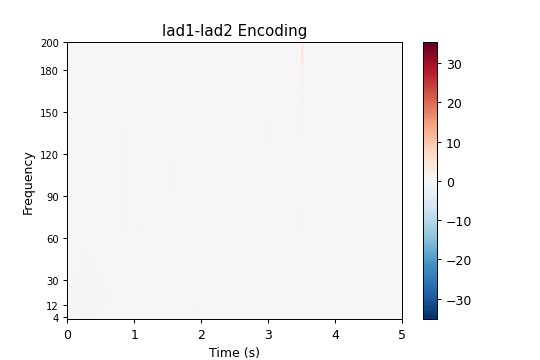

<IPython.core.display.Javascript object>


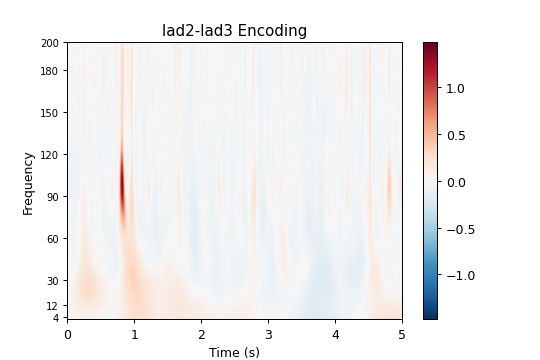

<IPython.core.display.Javascript object>


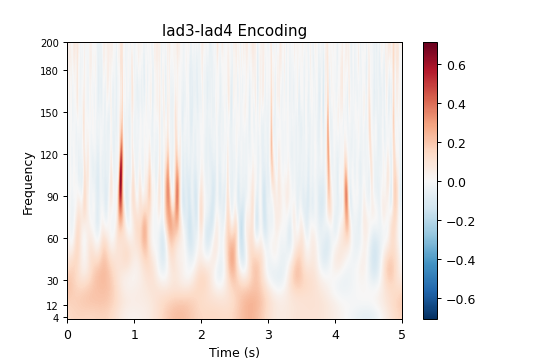

<IPython.core.display.Javascript object>


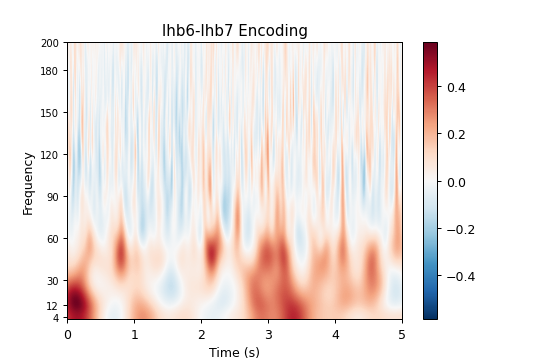

<IPython.core.display.Javascript object>


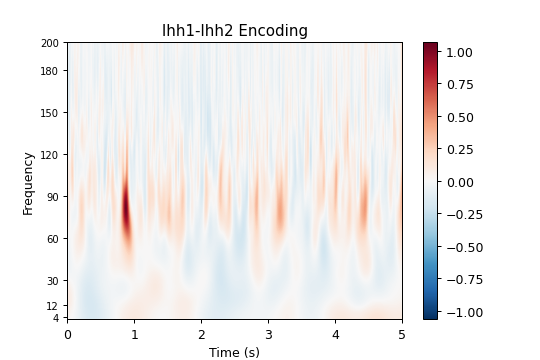

<IPython.core.display.Javascript object>


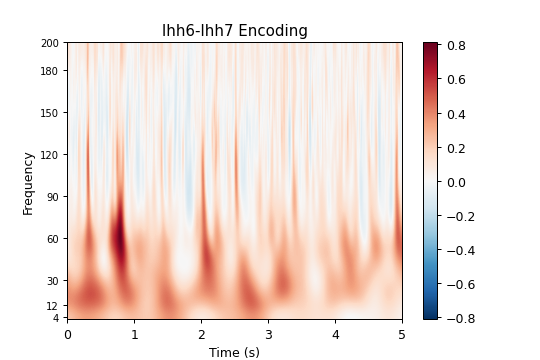

<IPython.core.display.Javascript object>


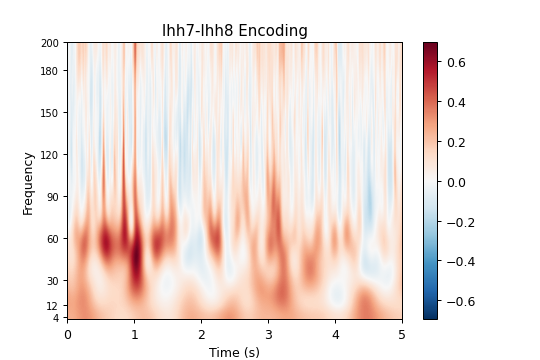

<IPython.core.display.Javascript object>


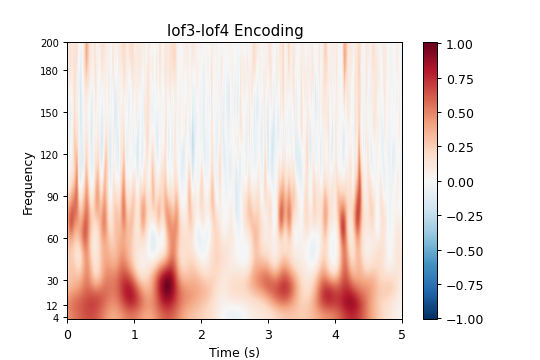

<IPython.core.display.Javascript object>


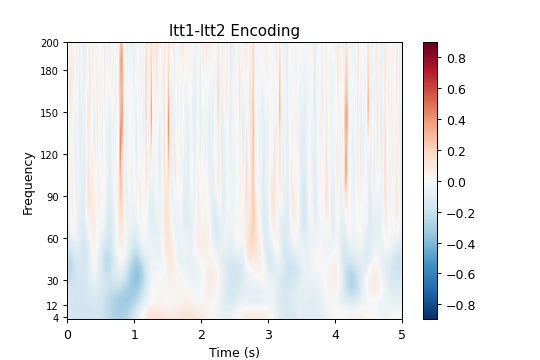

<IPython.core.display.Javascript object>


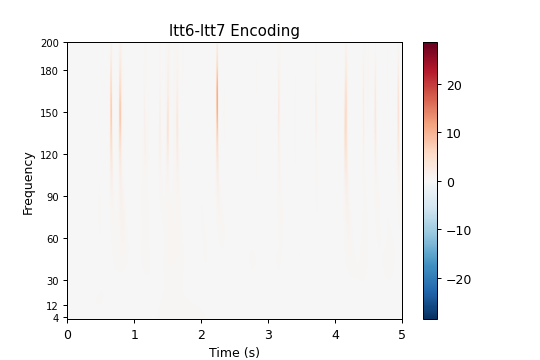

<IPython.core.display.Javascript object>


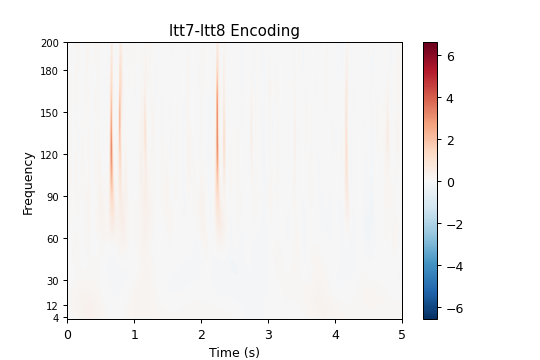

In [2114]:
event = 'DecisionOnset'
yticks = [4, 12, 30, 60, 90, 120, 150, 180, 200]
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir

print(offset)


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    times = power_epochs[event].times
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,
            extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), vmax = np.nanmax(np.abs(plot_data)))
    ax.set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding')
    ax.yaxis.set_tick_params(labelsize=8)
    fig.colorbar(im, ax=ax)
    plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
#     plt.close()
